[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sparks-baird/self-driving-lab-demo/blob/main/notebooks/6.2.2-multi-fidelity-discrete.ipynb)

# Discrete Multi-fidelity Optimization

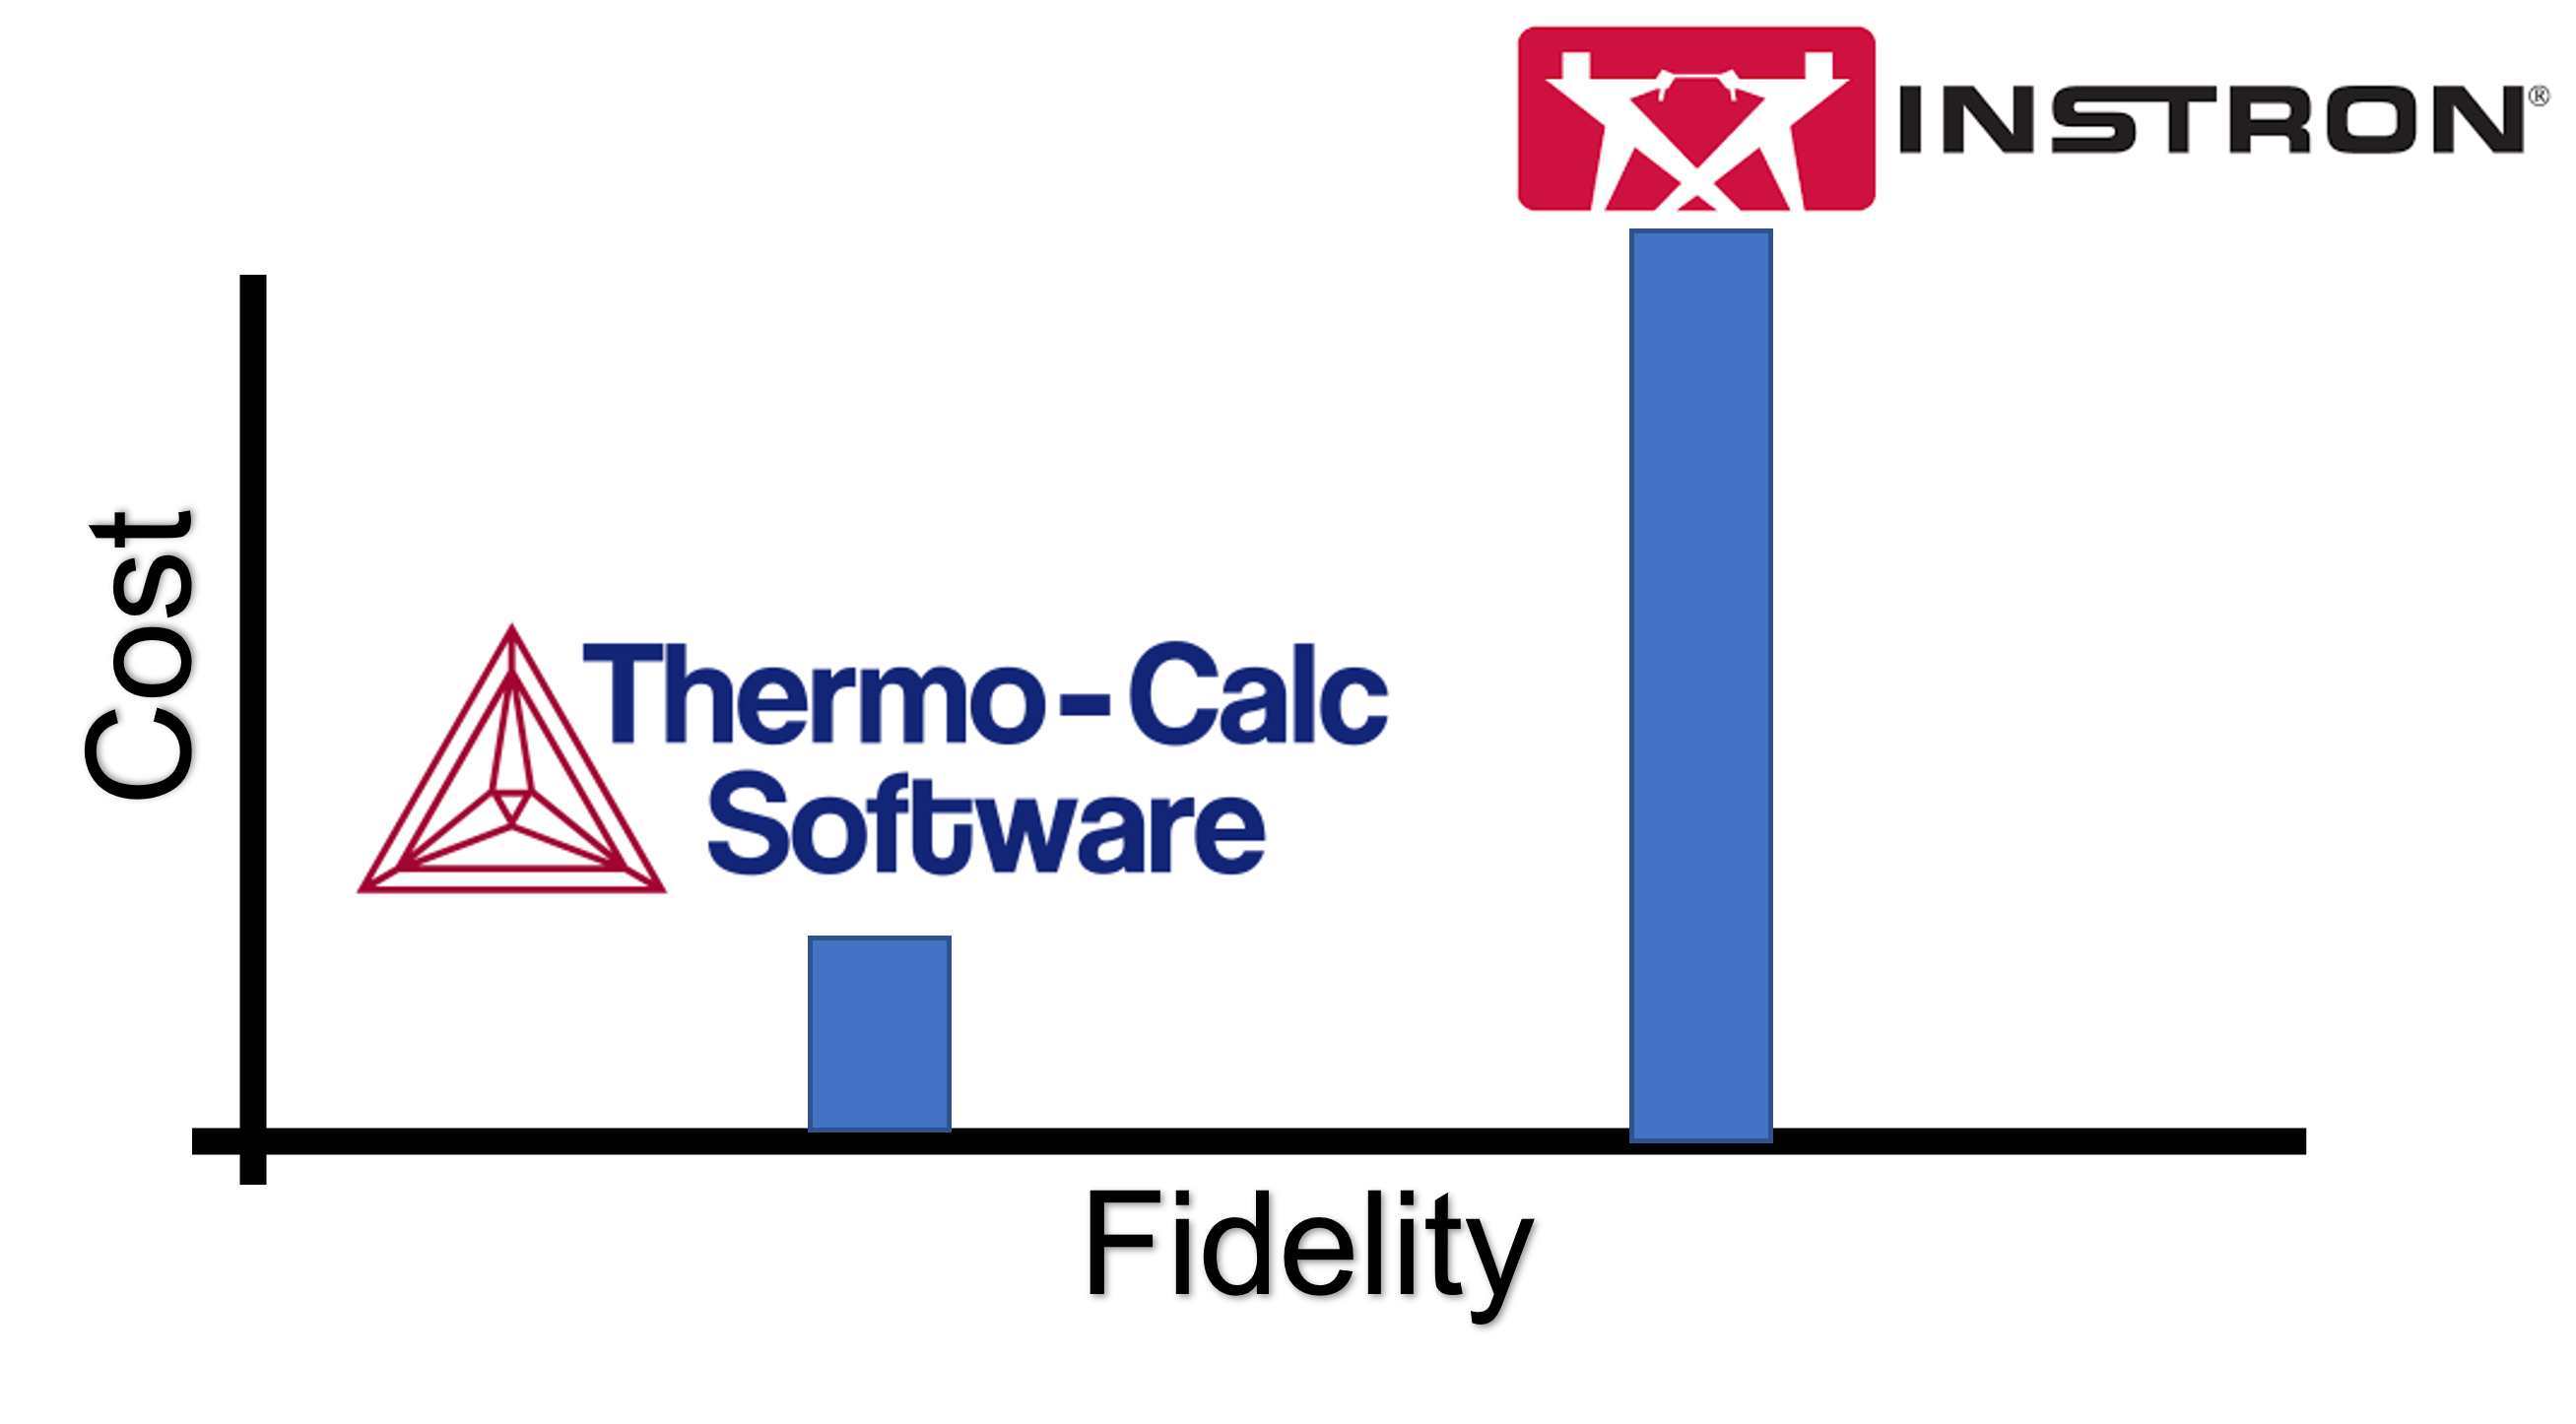

In [1]:
# For notebook gallery thumbnail
from IPython.display import Image
Image(filename="discrete-multi-fidelity.png")



In this tutorial, we show how to do multi-fidelity BO with discrete fidelities based on [1], where each fidelity is a different "information source." This tutorial uses the same setup as the [continuous multi-fidelity BO tutorial](https://botorch.org/tutorials/multi_fidelity_bo), except with discrete fidelity parameters that are interpreted as multiple information sources.

We use a GP model with a single task that models the design and fidelity parameters jointly. In some cases, where there is not a natural ordering in the fidelity space, it may be more appropriate to use a multi-task model (with, say, an ICM kernel). We will provide a tutorial once this functionality is in place.

[1] [M. Poloczek, J. Wang, P.I. Frazier. Multi-Information Source Optimization. NeurIPS, 2017](https://papers.nips.cc/paper/2017/file/df1f1d20ee86704251795841e6a9405a-Paper.pdf)

[2] [J. Wu, S. Toscano-Palmerin, P.I. Frazier, A.G. Wilson. Practical Multi-fidelity Bayesian Optimization for Hyperparameter Tuning. Conference on Uncertainty in Artificial Intelligence (UAI), 2019](https://arxiv.org/pdf/1903.04703.pdf)

## Set dtype and device

In [1]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
# SMOKE_TEST = os.environ.get("SMOKE_TEST")
SMOKE_TEST = True

## Problem setup

We'll consider the Augmented Hartmann multi-fidelity synthetic test problem. This function is a version of the Hartmann6 test function with an additional dimension representing the fidelity parameter; details are in [2]. The function takes the form $f(x,s)$ where $x \in [0,1]^6$ and $s \in \{0.5, 0.75, 1\}$. The target fidelity is 1.0, which means that our goal is to solve $\max_x f(x,1.0)$ by making use of cheaper evaluations $f(x,s)$ for $s \in \{0.5, 0.75\}$. In this example, we'll assume that the cost function takes the form $5.0 + s$, illustrating a situation where the fixed cost is $5.0$.

In [5]:
from botorch.test_functions.multi_fidelity import AugmentedHartmann
from botorch.test_functions.synthetic import SyntheticTestFunction
import pandas as pd
from torch import Tensor

from self_driving_lab_demo import SelfDrivingLabDemoLight, mqtt_observe_sensor_data


class SelfDrivingLabDiscreteFidelity(SyntheticTestFunction):
    def __init__(self, negate=False, s=20.0):
        self.columns = ["R", "G", "B", "simulation"]
        self.design_vars = ["R", "G", "B"]
        # compute set difference between self.columns and self.design_vars
        self.fidelity_vars = list(set(self.columns) - set(self.design_vars))
        self.dim = len(self.columns)
        self.num_design = len(self.design_vars)
        self.num_fidelity = len(self.fidelity_vars)
        self.fidelity_columns = [
            self.columns.index(f) for f in self.fidelity_vars
        ]
        target_seed = 10
        self.sdl_sim = SelfDrivingLabDemoLight(
            simulation=True, autoload=True, target_seed=target_seed
        )
        self.sdl_exp = SelfDrivingLabDemoLight(
            simulation=True,  # change back to False when ready
            autoload=True,
            target_seed=target_seed,
            observe_sensor_data_fn=mqtt_observe_sensor_data,
            observe_sensor_data_kwargs=dict(pico_id="test"),
        )
        self._bounds = [self.sdl_exp.bounds[key] for key in self.design_vars]
        self._bounds += [(0.0, s)]
        self.dim = len(self._bounds)
        super().__init__(negate=negate)
        # self._optimal_value = 0.0
        # self._optimizers = [(0.0, 0.0)]

    def evaluate_true(self, X: Tensor) -> Tensor:
        # df = pd.DataFrame(
        #     X.detach().cpu().numpy(), columns=columns
        # ).to_dict("records")
        parameters = {key: x for key, x in zip(self.columns, X.detach().cpu().numpy())}
        simulation = parameters.pop("simulation")
        if simulation == 0.0:
            obj = self.sdl_sim.evaluate(parameters)["frechet"]
        else:
            obj = self.sdl_exp.evaluate(parameters)["frechet"]
        # convert to tensor
        obj = torch.tensor(obj, **tkwargs)
        return obj


# simulation cost: 5, experiment cost: 25
s = 20.0
fidelities = torch.tensor([0.0, s], **tkwargs)

sdl_discrete = SelfDrivingLabDiscreteFidelity(s=s)
# problem = AugmentedHartmann(negate=True).to(**tkwargs)

In [6]:
sdl_discrete.evaluate_true(torch.tensor([10.0, 11.0, 12.0, 20.0], **tkwargs))

tensor(137355.3348, dtype=torch.float64)

### Model initialization

We use a `SingleTaskMultiFidelityGP` as the surrogate model, which uses a kernel from [2] that is well-suited for multi-fidelity applications. The `SingleTaskMultiFidelityGP` models the design and fidelity parameters jointly, so its domain is $[0,1]^7$.

In [7]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


def generate_initial_data(n=16):
    # generate training data
    train_x = [sdl_discrete.sdl_exp.get_random_inputs() for _ in range(n)]
    train_x = torch.tensor(pd.DataFrame(train_x).to_numpy(), **tkwargs)
    train_f = fidelities[torch.randint(len(fidelities), (n, 1))]
    train_x_full = torch.cat((train_x, train_f), dim=1)
    train_obj = [sdl_discrete.evaluate_true(x) for x in train_x_full]
    # add output dimension
    train_obj = torch.tensor(train_obj).unsqueeze(-1)
    return train_x_full, train_obj


def initialize_model(train_x, train_obj):
    # define a surrogate model suited for a "training data"-like fidelity parameter
    # in dimension 6, as in [2]
    model = SingleTaskMultiFidelityGP(
        train_x,
        train_obj,
        outcome_transform=Standardize(m=1),
        data_fidelity=sdl_discrete.fidelity_columns[0],
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

### Define a helper function to construct the MFKG acquisition function
The helper function illustrates how one can initialize an $q$MFKG acquisition function. In this example, we assume that the affine cost is known. We then use the notion of a `CostAwareUtility` in BoTorch to scalarize the "competing objectives" of information gain and cost. The MFKG acquisition function optimizes the ratio of information gain to cost, which is captured by the `InverseCostWeightedUtility`.

In order for MFKG to evaluate the information gain, it uses the model to predict the function value at the highest fidelity after conditioning on the observation. This is handled by the `project` argument, which specifies how to transform a tensor `X` to its target fidelity. We use a default helper function called `project_to_target_fidelity` to achieve this.

An important point to keep in mind: in the case of standard KG, one can ignore the current value and simply optimize the expected maximum posterior mean of the next stage. However, for MFKG, since the goal is optimize information *gain* per cost, it is important to first compute the current value (i.e., maximum of the posterior mean at the target fidelity). To accomplish this, we use a `FixedFeatureAcquisitionFunction` on top of a `PosteriorMean`.

In [12]:
from botorch import fit_gpytorch_mll
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition import PosteriorMean
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.utils import project_to_target_fidelity

bounds = torch.tensor(
    [[0.0] * sdl_discrete.dim, [1.0] * (sdl_discrete.dim - 1) + [s]], **tkwargs
)
# find position of sdl.fidelity_vars in sdl.columns
fidelity_column = sdl_discrete.fidelity_columns[0]
target_fidelities = {fidelity_column: s}

fixed_features_list = [{fidelity_column: 0.0}, {fidelity_column: s}]

cost_model = AffineFidelityCostModel(
    fidelity_weights={fidelity_column: 1.0}, fixed_cost=5.0
)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)


def project(X):
    return project_to_target_fidelity(X=X, target_fidelities=target_fidelities)

max_rgb = 89.0

def get_mfkg(model):

    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=sdl_discrete.dim,
        columns=sdl_discrete.fidelity_columns,
        values=[20.0],
    )

    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:, :-1],
        q=1,
        num_restarts=10 if not SMOKE_TEST else 2,
        raw_samples=1024 if not SMOKE_TEST else 4,
        options={"batch_limit": 10, "maxiter": 200},
    )

    return qMultiFidelityKnowledgeGradient(
        model=model,
        num_fantasies=128 if not SMOKE_TEST else 2,
        current_value=current_value,
        cost_aware_utility=cost_aware_utility,
        project=project,
    )

### Define a helper function that performs the essential BO step
This helper function optimizes the acquisition function and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. The function `optimize_acqf_mixed` sequentially optimizes the acquisition function over $x$ for each value of the fidelity $s \in \{0, 0.5, 1.0\}$.

In [13]:
from botorch.optim.optimize import optimize_acqf_mixed


torch.set_printoptions(precision=3, sci_mode=False)

NUM_RESTARTS = 5 if not SMOKE_TEST else 2
RAW_SAMPLES = 128 if not SMOKE_TEST else 4
BATCH_SIZE = 4


def optimize_mfkg_and_get_observation(mfkg_acqf):
    """Optimizes MFKG and returns a new candidate, observation, and cost."""

    # generate new candidates
    candidates, _ = optimize_acqf_mixed(
        acq_function=mfkg_acqf,
        bounds=bounds,
        fixed_features_list=fixed_features_list,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        # batch_initial_conditions=X_init,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    new_obj = sdl_discrete.evaluate_true(new_x).unsqueeze(-1)
    print(f"candidates:\n{new_x}\n")
    print(f"observations:\n{new_obj}\n\n")
    return new_x, new_obj, cost

## Perform a few steps of multi-fidelity BO
First, let's generate some initial random data and fit a surrogate model.

In [14]:
train_x, train_obj = generate_initial_data(n=4)

We can now use the helper functions above to run a few iterations of BO.

In [15]:
cumulative_cost = 0.0
N_ITER = 3 if not SMOKE_TEST else 1

for i in range(N_ITER):
    mll, model = initialize_model(train_x, train_obj)
    fit_gpytorch_mll(mll)
    mfkg_acqf = get_mfkg(model)
    new_x, new_obj, cost = optimize_mfkg_and_get_observation(mfkg_acqf)
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    cumulative_cost += cost

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Make a final recommendation
In multi-fidelity BO, there are usually fewer observations of the function at the target fidelity, so it is important to use a recommendation function that uses the correct fidelity. Here, we maximize the posterior mean with the fidelity dimension fixed to the target fidelity of 1.0.

In [14]:
def get_recommendation(model):
    rec_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=7,
        columns=[6],
        values=[1],
    )

    final_rec, _ = optimize_acqf(
        acq_function=rec_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )
    
    final_rec = rec_acqf._construct_X_full(final_rec)
    
    objective_value = problem(final_rec)
    print(f"recommended point:\n{final_rec}\n\nobjective value:\n{objective_value}")
    return final_rec

In [15]:
final_rec = get_recommendation(model)
print(f"\ntotal cost: {cumulative_cost}\n")

recommended point:
tensor([[0.181, 0.203, 0.447, 0.249, 0.361, 0.366, 1.000]],
       dtype=torch.float64)

objective value:
tensor([1.627], dtype=torch.float64)

total cost: 72.0



## Comparison to standard EI (always use target fidelity)
Let's now repeat the same steps using a standard EI acquisition function (note that this is not a rigorous comparison as we are only looking at one trial in order to keep computational requirements low).

In [10]:
from botorch.acquisition import qExpectedImprovement


def get_ei(model, best_f):

    return FixedFeatureAcquisitionFunction(
        acq_function=qExpectedImprovement(model=model, best_f=best_f),
        d=7,
        columns=[6],
        values=[1],
    )


def optimize_ei_and_get_observation(ei_acqf):
    """Optimizes EI and returns a new candidate, observation, and cost."""

    candidates, _ = optimize_acqf(
        acq_function=ei_acqf,
        bounds=bounds[:, :-1],
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # add the fidelity parameter
    candidates = ei_acqf._construct_X_full(candidates)

    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    new_obj = problem(new_x).unsqueeze(-1)
    print(f"candidates:\n{new_x}\n")
    print(f"observations:\n{new_obj}\n\n")
    return new_x, new_obj, cost

In [11]:
cumulative_cost = 0.0

train_x, train_obj = generate_initial_data(n=16)

for _ in range(N_ITER):
    mll, model = initialize_model(train_x, train_obj)
    fit_gpytorch_mll(mll)
    ei_acqf = get_ei(model, best_f=train_obj.max())
    new_x, new_obj, cost = optimize_ei_and_get_observation(ei_acqf)
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    cumulative_cost += cost

c:\Users\sterg\Miniconda3\envs\sdl-demo\lib\site-packages\botorch\optim\optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
c:\Users\sterg\Miniconda3\envs\sdl-demo\lib\site-packages\botorch\optim\optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


candidates:
tensor([[0.224, 0.188, 0.264, 0.293, 0.413, 0.167, 1.000],
        [0.251, 0.145, 0.393, 0.232, 0.399, 0.332, 1.000],
        [0.103, 0.000, 0.307, 0.378, 0.371, 0.317, 1.000],
        [0.000, 0.000, 0.363, 0.175, 0.397, 0.164, 1.000]],
       dtype=torch.float64)

observations:
tensor([[0.374],
        [1.226],
        [0.932],
        [0.306]], dtype=torch.float64)




c:\Users\sterg\Miniconda3\envs\sdl-demo\lib\site-packages\botorch\optim\optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
c:\Users\sterg\Miniconda3\envs\sdl-demo\lib\site-packages\botorch\optim\optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


candidates:
tensor([[0.195, 0.190, 0.432, 0.251, 0.371, 0.350, 1.000],
        [0.543, 0.448, 0.860, 0.733, 0.257, 0.161, 1.000],
        [0.851, 0.099, 0.049, 0.496, 0.351, 0.991, 1.000],
        [0.266, 0.076, 0.351, 0.205, 0.417, 0.354, 1.000]],
       dtype=torch.float64)

observations:
tensor([[1.488],
        [0.339],
        [0.219],
        [1.187]], dtype=torch.float64)


candidates:
tensor([[0.164, 0.219, 0.469, 0.240, 0.345, 0.387, 1.000],
        [0.359, 0.828, 0.841, 0.537, 0.237, 0.849, 1.000],
        [0.593, 0.267, 0.045, 0.860, 0.656, 0.212, 1.000],
        [0.861, 0.489, 0.126, 0.718, 0.422, 0.692, 1.000]],
       dtype=torch.float64)

observations:
tensor([[1.802],
        [0.281],
        [0.024],
        [0.069]], dtype=torch.float64)




In [12]:
final_rec = get_recommendation(model)
print(f"\ntotal cost: {cumulative_cost}\n")

recommended point:
tensor([[0.181, 0.203, 0.447, 0.249, 0.361, 0.366, 1.000]],
       dtype=torch.float64)

objective value:
tensor([1.627], dtype=torch.float64)

total cost: 72.0



## Code Graveyard

In [12]:
# def generate_initial_data(n=16):
#     # generate training data
#     train_x = np.random.rand(n, 3)
#     train_x = pd.DataFrame(train_x, columns=["R", "G", "B"])
#     train_f = np.random.choice(fidelities, (n, 1))
#     train_f = pd.DataFrame(train_f, columns=["simulation"])
#     train_x_full = pd.concat((train_x, train_f), axis=1).to_dict("records")
#     train_obj = [sdl.evaluate(train_x_full[i])["frechet"] for i in range(n)]
#     # convert to tensors
#     train_x_full = torch.tensor(pd.DataFrame(train_x_full).to_numpy(), **tkwargs)
#     train_obj = torch.tensor(train_obj, **tkwargs).unsqueeze(-1)  # add output dimension

#     # train_x = torch.rand(n, 6, **tkwargs)
#     # train_f = fidelities[torch.randint(), (n, 1))]
#     # train_x_full = torch.cat((train_x, train_f), dim=1)
#     # train_obj = problem(train_x_full).unsqueeze(-1)  # add output dimension

#     return train_x_full, train_obj